In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tools.ImageOperate import hist_cut, hist_remap, clahe_equalize, pyr_down

In [ ]:
# Load the image
path = r'D:\Fenkx\Fenkx - General\Ubei\Test_Label1'
for index, item in enumerate(os.listdir(path)):
	file = os.path.join(path, item)
	if os.path.isfile(file):
		image_source = cv2.imdecode(np.fromfile(file, dtype=np.uint8), 1)
		try:
			image_cut = hist_cut(image_source)
		finally:
			filename = os.path.splitext(item)
			new_name = filename[0] + filename[-1]
			result_path = os.path.join(path, 'image_cut')
			if not os.path.exists(result_path):
				os.makedirs(result_path)
			cv2.imwrite(os.path.join(result_path, new_name), image_cut)
print('finished!')

(571, 855, 3)


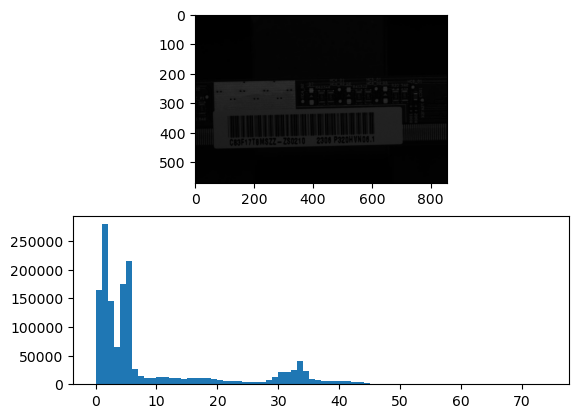

In [4]:
file = r'D:\Fenkx\Fenkx - General\AI\Dataset\BarCode\My Datasets\Test_Label\C1\C83F17T8MSZZZS0210_NG_BarCode_Camera3_0211100946.jpg'
image_source = cv2.imdecode(np.fromfile(file, dtype=np.uint8), 1)
image_pydown=pyr_down(image_source)
print(image_pydown[-1].shape)
# plt.figure(dpi=200)
plt.subplot(2,1,1)
plt.imshow(image_pydown[-1])
plt.subplot(2,1,2)
plt.hist(image_pydown[-1].ravel(), np.max(image_pydown[-1]), [0, np.max(image_pydown[-1])])
plt.show()

Function hist_cut took 27.00ms to run


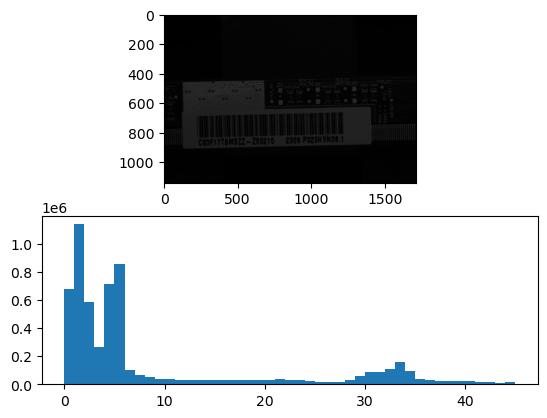

In [7]:
image_cut = hist_cut(image_source, 500)
plt.subplot(2,1,1)
plt.imshow(image_cut)
plt.subplot(2,1,2)
plt.hist(image_cut.ravel(),np.max(image_cut) , [0, np.max(image_cut)])
plt.show()

In [ ]:

image_eq = clahe_equalize(image_cut)
cv2.namedWindow('result', cv2.WINDOW_NORMAL | cv2.WINDOW_KEEPRATIO)
cv2.imshow('result', cv2.vconcat((image_cut, image_eq)))
if cv2.waitKey(0) == 27:
	cv2.destroyAllWindows()


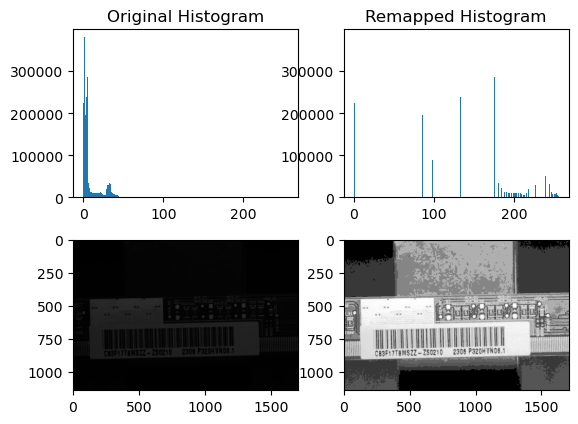

In [5]:

from tools.ImageOperate import hist_remap

file = r'D:\Fenkx\Fenkx - General\AI\Dataset\BarCode\My Datasets\Test_Label\C1\C83F17T8MSZZZS0210_NG_BarCode_Camera3_0211100946.jpg'
image_source = cv2.imdecode(np.fromfile(file, dtype=np.uint8), 0)
#直方图均衡化
equ = cv2.equalizeHist(image_source)

# 绘制原始图像的灰度直方图和更改分布后的灰度直方图
plt.subplot(2, 2, 1)
plt.hist(image_source.ravel(), 256, [0, 256])
plt.title("Original Histogram")
plt.subplot(2, 2, 2)
plt.hist(equ.ravel(), 256, [0, 256])
plt.title("Remapped Histogram")

plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(image_source, cv2.COLOR_BGR2RGB))
plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(equ, cv2.COLOR_BGR2RGB))
plt.show()
cv2.imshow('equ', equ)
cv2.waitKey(0)
cv2.destroyAllWindows()


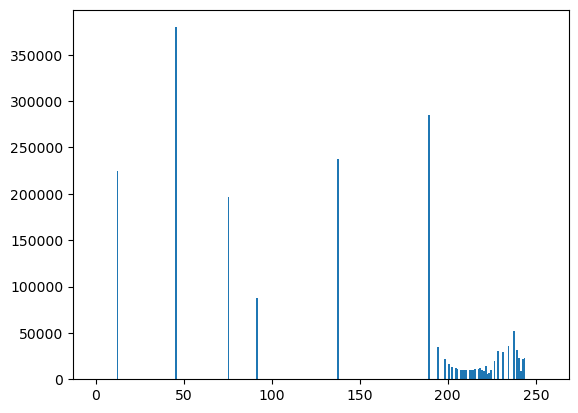

In [16]:
    # 统计灰度直方图
from scipy.stats import norm

hist, bins = np.histogram(equ.ravel(), 256, [0, 256])
# 计算直方图的均值和标准差
mean = np.mean(equ)
std = np.std(equ)
# 映射灰度直方图到正态分布
x = (bins - mean) / std
remap_hist = norm.cdf(x)
# 计算像素值映射表
lut = np.uint8(remap_hist * 255)[:-1]
# 应用像素值映射表，输出更改分布后的图像
remap_img = cv2.LUT(equ, lut)
plt.hist(remap_img.ravel(), 256, [0, 256])
plt.show()
cv2.imshow('equ', equ)
cv2.waitKey(0)
cv2.destroyAllWindows()
